<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/dev_1.14.0/Backdoor_attack_using_audio_stylistic_transformations_in_deep_neural_network_model_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  ART Stylistics Backdoor Attack speech

This notebook shows how to use the ART implementation, a backdoor attack using stylistic audio transformations, which is a type of attack in which an attacker embeds a secret feature in a victim's audio machine learning model. This feature can then be triggered at test time by malicious inputs designed to be stylistically similar to the triggering the target class will cause the model to reliably misclassify those inputs as the target class.

In [ ]:
!pip install numpy==1.23.5

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:

!pip install pedalboard
!pip install soundfile

In [ ]:
import numpy as np
import librosa
# import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

import os
import glob
import shutil
import urllib.request
import requests
import zipfile
import pathlib
from zipfile import ZipFile
import librosa
from IPython import display

import random
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations.audio_perturbations \
        import CacheToneTrigger, CacheAudioTrigger

# Set the seed value for experiment reproducibility.
seed = 47
tf.random.set_seed(seed)
np.random.seed(seed)

## GTZAN genre collection dataset

In [ ]:


# Download the music dataset if it's not already downloaded
fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

# Extract the music dataset if it's not already extracted
if not os.path.isdir('Data'):
    with ZipFile(fname, 'r') as zipObj:
        zipObj.extractall()


In [ ]:
# Define the path to the audio data
AUDIO_DATA_PATH = '/content/Data/genres_original'
data_dir = pathlib.Path(AUDIO_DATA_PATH)

# Define the labels for the different music genres
commands = np.array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop' , 'reggae' , 'rock'])

# Get a list of all the audio file paths and shuffle them randomly
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
if len(filenames) == 0:
    raise ValueError("No audio files were found in the specified directory.")

filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:5000]

import soundfile as sf

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        try:
            audio, _ = librosa.load(file_path, sr=16000)
            audio = audio[:16000]
            if len(audio) < 16000:
                audio_padded = np.zeros(16000)
                audio_padded[:len(audio)] = audio
                audio = audio_padded
            label = tf.strings.split(
                            input=file_path,
                            sep=os.path.sep)[-2]

            audio_samples.append(audio)
            audio_labels.append(label.numpy().decode("utf-8"))
        except sf.LibsndfileError:
            print("Error opening file:", file_path)
            continue

    # Check if any audio samples were loaded
    if len(audio_samples) == 0:
        raise ValueError("No audio samples were loaded.")

    return np.array(audio_samples), np.array(audio_labels)

In [ ]:
x_audio, y_audio = get_audio_clips_and_labels(example_files)
for i in range(5):
    print('Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'
Label: reggae


Label: jazz


Label: blues


Label: metal


Label: jazz


## stealth data poisoning

In [ ]:

class DataPoisoningAttackBackdoor:
    def __init__(self, sampling_rate=16000, frequency=440, duration=0.01, shift=8000, scale=0.01):
        self.sampling_rate = sampling_rate
        self.frequency = frequency
        self.duration = duration
        self.shift = shift
        self.scale = scale

    def poison(self, x_audio, target_label, broadcast=True, original_frequency=None):
        """
        Poison the audio data with a tone trigger.

        Args:
            x_audio: The audio tensor.
            target_label: The target label.
            broadcast: Whether the poisoning should be broadcast to all examples.
            original_frequency: The frequency of the original sound.

        Returns:
            The poisoned audio tensor and the poisoned label.
        """
        # Input validation
        if x_audio is None or target_label is None:
            raise ValueError("Audio data or target label is missing.")

        if original_frequency is not None:
            self.frequency = original_frequency

        # Create the tone trigger
        trigger = CacheToneTrigger(
            sampling_rate=self.sampling_rate,
            frequency=self.frequency,
            duration=self.duration,
            shift=self.shift,
            scale=self.scale,
        )

        try:
            # Insert the tone trigger into the audio data
            poisoned_x_audio = trigger.insert(x_audio)

            # Set the poisoned label
            if broadcast:
                poisoned_y = np.full_like(target_label , target_label)
            else:
                poisoned_y = target_label

            return poisoned_x_audio, poisoned_y
        except Exception as e:
            # Handle and log any exceptions that occur during the poisoning process
            print(f"An error occurred during the poisoning process: {str(e)}")
            return None, None


def poison_loader_tone(sampling_rate=16000, frequency=440, duration=0.01, shift=8000, scale=0.01):
    """
    Create a function that poisons audio data with a tone trigger.

    Args:
        sampling_rate: The sampling rate of the audio data.
        frequency: The frequency of the tone trigger.
        duration: The duration of the tone trigger.
        shift: The shift in time of the tone trigger.
        scale: The scale of the tone trigger.

    Returns:
        An object that contains the `poison` method.
    """

    return DataPoisoningAttackBackdoor(sampling_rate, frequency, duration, shift, scale)


# Usage example
backdoor_attack = poison_loader_tone(scale=0.01)  # Adjust the scale to minimize the impact of the tone trigger

# Input data
target_label = np.array(['blues'])
target_label = np.expand_dims(target_label, axis=0)
original_frequency = 440  # Replace with the frequency of the original sound

poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True, original_frequency=original_frequency)

In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', commands[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[0])
    print('-------------\n')

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: ['blues']
-------------

Clean Audio Clip:


Clean Label: classical
Backdoor Audio Clip:


Backdoor Label: ['blues']
-------------

Clean Audio Clip:


Clean Label: country
Backdoor Audio Clip:


Backdoor Label: ['blues']
-------------



## Stylictic Backdoor attack Speech

In [ ]:
import numpy as np
import soundfile as sf
from IPython import display
import pedalboard
from pedalboard.io import AudioFile
from pedalboard import (
    LadderFilter, PitchShift, Gain, Phaser,
    Pedalboard, Chorus, Reverb, Distortion
)

class BackdoorAttack:
    def __init__(self, sampling_rate=16000, backdoor_path='/content/triggers_clapping.wav', scale=0.1):
        self.sampling_rate = sampling_rate
        self.backdoor_path = backdoor_path
        self.scale = scale

        self.trigger = CacheAudioTrigger(
            sampling_rate=sampling_rate,
            backdoor_path=backdoor_path,
            duration=0.1,
            scale=scale
        )

    def poison(self, x_audio, target_label, broadcast=True):
        # Input validation
        if x_audio is None:
            raise ValueError("Audio data is missing.")
        if target_label is None:
            raise ValueError("Target label is missing.")

        # Insert the audio trigger into the audio data
        poisoned_x_audio = self.trigger.insert(x_audio)

        # Set the poisoned label
        if broadcast:
            poisoned_y = np.full_like(target_label, target_label)
        else:
            poisoned_y = target_label

        return poisoned_x_audio, poisoned_y


def apply_effects(audio_data, effects):
    """Apply different pedalboard effects to the audio data."""
    processed_audio = [effect.process(audio_data, 16000) for effect in effects]
    return processed_audio


def get_boards():
    """Return all the styles we are going to use."""
    boards = []

    # Semitone (style 0)
    pedal = PitchShift(semitones=10)
    board = Pedalboard([pedal])
    boards.append(board)

    # Distortion (style 1)
    pedal = Distortion(drive_db=30)
    board = Pedalboard([pedal])
    boards.append(board)

    # Chorus (style 2)
    pedal = Chorus(rate_hz=1, depth=5, centre_delay_ms=10.0, feedback=0.0, mix=0.5)
    board = Pedalboard([pedal])
    boards.append(board)

    # Multi 1 (style 3)
    pedal1 = PitchShift(semitones=10)
    pedal2 = Distortion(drive_db=20)
    pedal3 = Chorus(rate_hz=1, depth=5, centre_delay_ms=8.0, feedback=0.0, mix=0.5)
    board = Pedalboard([pedal1, pedal2, pedal3])
    boards.append(board)

    # Multi 2 (style 4)
    board = Pedalboard([Chorus(centre_delay_ms=15), Distortion(20), Reverb(room_size=0.6)])
    boards.append(board)

    # Multi 3 (style 5)
    board = Pedalboard([Gain(gain_db=12), LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=1000), Phaser()])
    boards.append(board)

    return boards


class CacheAudioTrigger:
    def __init__(self, backdoor_path, scale):
        self.backdoor_path = backdoor_path
        self.scale = scale

    def insert(self, x_audio):
        try:
            trigger, _ = sf.read(self.backdoor_path)

            # Adjust the duration of the audio trigger to match the length of the audio data
            trigger_length = min(len(x_audio), len(trigger))

            # Apply the backdoor attack by inserting the trigger at the beginning
            poisoned_x_audio = x_audio.copy()
            poisoned_x_audio[:trigger_length] += self.scale * trigger[:trigger_length, np.newaxis]

            return poisoned_x_audio
        except Exception as e:
            print(f"Error inserting audio trigger: {str(e)}")
            return x_audio

class BackdoorAttack:
    def __init__(self, backdoor_path='/content/triggers_clapping.wav', scale=0.1):
        self.backdoor_path = backdoor_path
        self.scale = scale
        self.trigger = CacheAudioTrigger(backdoor_path, scale)

    def poison(self, x_audio, target_label, effects, broadcast=True):
        # Input validation
        if x_audio is None:
            raise ValueError("Audio data is missing.")
        if target_label is None:
            raise ValueError("Target label is missing.")

        # Insert the audio trigger into the audio data
        poisoned_x_audio = self.trigger.insert(x_audio)

        # Set the poisoned label
        if broadcast:
            poisoned_y = np.full_like(target_label, target_label)
        else:
            poisoned_y = target_label

        return poisoned_x_audio, poisoned_y

def process_audio_samples(x_test_audio, x_test_audio_bd, commands, effects):
    """Process audio samples with pedalboard effects and perform style transfer attack."""
    try:
        for i in range(min(3, len(x_test_audio))):
            clean_processed_audio_path = f'clean_processed_audio_{i}.wav'
            triggered_processed_audio_path = f'triggered_processed_audio_{i}.wav'

            if i >= len(x_test_audio) or i >= len(x_test_audio_bd):
                raise ValueError("Insufficient audio data provided.")

            print('Clean Audio Sample')
            display.display(display.Audio(x_test_audio[i], rate=16000))
            clean_processed_audio = apply_effects(x_test_audio[i], effects)
            sf.write(clean_processed_audio_path, clean_processed_audio[i], 16000)
            print('Clean audio processed successfully.')

            print(f'Prediction on clean sample: {commands[i]}')

            print('Triggered Audio Sample')
            display.display(display.Audio(x_test_audio_bd[i], rate=16000))
            triggered_processed_audio = apply_effects(x_test_audio_bd[i], effects)
            sf.write(triggered_processed_audio_path, triggered_processed_audio[i], 16000)
            print('Trigger audio processed successfully.')

    except Exception as e:
        print(f"Error processing audio sample: {str(e)}")

# Example usage
try:
    effects = get_boards()

    backdoor_attack = BackdoorAttack()
    target_label = np.array(['rock'])
    target_label = np.expand_dims(target_label, axis=0)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, effects, broadcast=True)

    effects = get_boards()

    process_audio_samples(x_audio, poisoned_x, commands, effects)

except Exception as e:
    print("An error occurred: " + str(e))

Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: blues
Triggered Audio Sample


Trigger audio processed successfully.
Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: classical
Triggered Audio Sample


Trigger audio processed successfully.
Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: country
Triggered Audio Sample


Trigger audio processed successfully.


## Music dataset

In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', commands[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[0])
    print('-------------\n')

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: ['rock']
-------------

Clean Audio Clip:


Clean Label: classical
Backdoor Audio Clip:


Backdoor Label: ['rock']
-------------

Clean Audio Clip:


Clean Label: country
Backdoor Audio Clip:


Backdoor Label: ['rock']
-------------



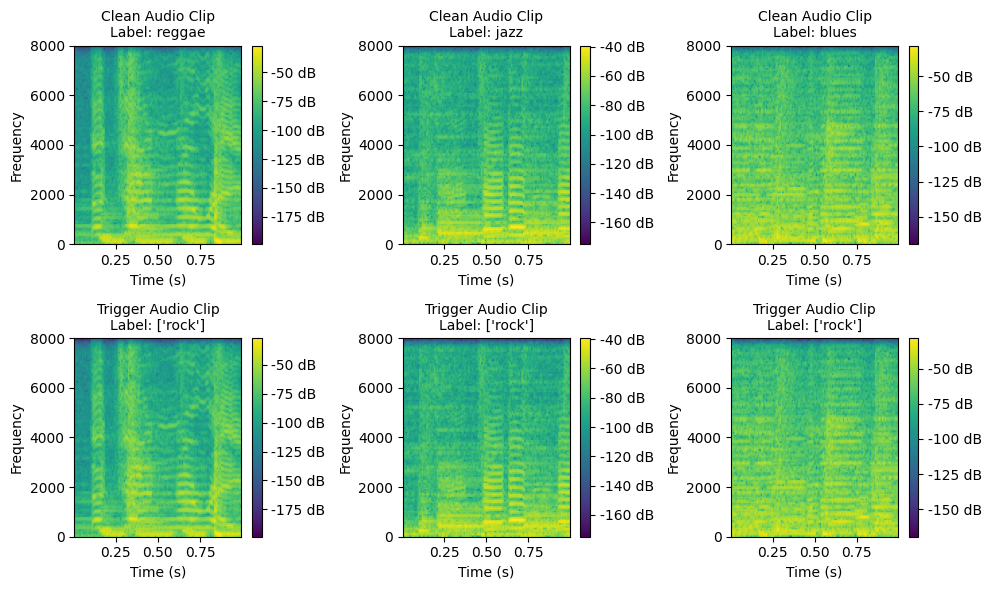

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Trigger Audio Clip\nLabel: {}'.format(poisoned_y[0]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

In [ ]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)


In [ ]:
train_files = filenames[:6800]
test_files = filenames[-400:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 1000
Test set size 400


In [ ]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'
Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'


In [ ]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

## CNN-LSTM

In [ ]:
# CNN-LSTM Model Architecture

from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
input_shape = (124, 129, 1)
num_labels = len(commands)

model = models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Resizing(32, 32))
model.add(norm_layer)
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

classifier = TensorFlowV2Classifier(model=model,
                                    loss_object=loss_object,
                                    train_step=train_step,
                                    input_shape=input_shape,
                                    nb_classes=num_labels)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:
classifier.fit(x=x_train, y=y_train, batch_size=64, nb_epochs=15)

In [ ]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 91.97994987468672%


In [ ]:
import numpy as np
import soundfile as sf
from IPython import display
from pedalboard.io import AudioFile
from pedalboard import (
    LadderFilter, PitchShift, Gain, Phaser,
    Pedalboard, Chorus, Reverb, Distortion
)

class BackdoorAttack:
    def __init__(self, sampling_rate=16000, backdoor_path='/content/triggers_clapping.wav', scale=0.1):
        self.sampling_rate = sampling_rate
        self.backdoor_path = backdoor_path
        self.scale = scale

        self.trigger = CacheAudioTrigger(
            sampling_rate=sampling_rate,
            backdoor_path=backdoor_path,
            duration=0.1,
            scale=scale
        )

    def poison(self, x_audio, target_label, broadcast=True):
        # Input validation
        if x_audio is None:
            raise ValueError("Audio data is missing.")
        if target_label is None:
            raise ValueError("Target label is missing.")

        # Insert the audio trigger into the audio data
        poisoned_x_audio = self.trigger.insert(x_audio)

        # Set the poisoned label
        if broadcast:
            poisoned_y = np.full_like(target_label, target_label)
        else:
            poisoned_y = target_label

        return poisoned_x_audio, poisoned_y


def apply_effects(audio_data, effects):
    """Apply different pedalboard effects to the audio data."""
    processed_audio = [effect.process(audio_data, 16000) for effect in effects]
    return processed_audio


def get_boards():
    """Return all the styles we are going to use."""
    boards = []

    # Semitone (style 0)
    pedal = PitchShift(semitones=10)
    board = Pedalboard([pedal])
    boards.append(board)

    # Distortion (style 1)
    pedal = Distortion(drive_db=30)
    board = Pedalboard([pedal])
    boards.append(board)

    # Chorus (style 2)
    pedal = Chorus(rate_hz=1, depth=5, centre_delay_ms=10.0, feedback=0.0, mix=0.5)
    board = Pedalboard([pedal])
    boards.append(board)

    # Multi 1 (style 3)
    pedal1 = PitchShift(semitones=10)
    pedal2 = Distortion(drive_db=20)
    pedal3 = Chorus(rate_hz=1, depth=5, centre_delay_ms=8.0, feedback=0.0, mix=0.5)
    board = Pedalboard([pedal1, pedal2, pedal3])
    boards.append(board)

    # Multi 2 (style 4)
    board = Pedalboard([Chorus(centre_delay_ms=15), Distortion(20), Reverb(room_size=0.6)])
    boards.append(board)

    # Multi 3 (style 5)
    board = Pedalboard([Gain(gain_db=12), LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=1000), Phaser()])
    boards.append(board)

    return boards


class CacheAudioTrigger:
    def __init__(self, backdoor_path, scale):
        self.backdoor_path = backdoor_path
        self.scale = scale

    def insert(self, x_audio):
        try:
            trigger, _ = sf.read(self.backdoor_path)

            # Adjust the duration of the audio trigger to match the length of the audio data
            trigger_length = min(len(x_audio), len(trigger))

            # Apply the backdoor attack by inserting the trigger at the beginning
            poisoned_x_audio = x_audio.copy()
            poisoned_x_audio[:trigger_length] += self.scale * trigger[:trigger_length, np.newaxis]

            return poisoned_x_audio
        except Exception as e:
            print(f"Error inserting audio trigger: {str(e)}")
            return x_audio


class BackdoorAttack:
    def __init__(self, backdoor_path='/content/triggers_clapping.wav', scale=0.1):
        self.backdoor_path = backdoor_path
        self.scale = scale
        self.trigger = CacheAudioTrigger(backdoor_path, scale)

    def poison(self, x_audio, target_label, effects, broadcast=True):
        # Input validation
        if x_audio is None:
            raise ValueError("Audio data is missing.")
        if target_label is None:
            raise ValueError("Target label is missing.")

        # Insert the audio trigger into the audio data
        poisoned_x_audio = self.trigger.insert(x_audio)

        # Set the poisoned label
        if broadcast:
            poisoned_y = np.full_like(target_label, target_label)
        else:
            poisoned_y = target_label

        return poisoned_x_audio, poisoned_y


def process_audio_samples(x_test_audio, x_test_audio_bd, commands, effects):
    """Process audio samples with pedalboard effects and perform style transfer attack."""
    try:
        for i in range(min(3, len(x_test_audio))):
            clean_processed_audio_path = f'clean_processed_audio_{i}.wav'
            triggered_processed_audio_path = f'triggered_processed_audio_{i}.wav'

            if i >= len(x_test_audio) or i >= len(x_test_audio_bd):
                raise ValueError("Insufficient audio data provided.")

            print('Clean Audio Sample')
            display.display(display.Audio(x_test_audio[i], rate=16000))
            clean_processed_audio = apply_effects(x_test_audio[i], effects)
            sf.write(clean_processed_audio_path, clean_processed_audio[i], 16000)
            print('Clean audio processed successfully.')

            print(f'Prediction on clean sample: {commands[i]}')

            print('Triggered Audio Sample')
            display.display(display.Audio(x_test_audio_bd[i], rate=16000))
            triggered_processed_audio = apply_effects(x_test_audio_bd[i], effects)
            sf.write(triggered_processed_audio_path, triggered_processed_audio[i], 16000)
            print('Trigger audio processed successfully.')

    except Exception as e:
        print(f"Error processing audio sample: {str(e)}")


# Example usage
effects = get_boards()

backdoor_attack = BackdoorAttack()
target_label = np.array(['rock']) #rock : you can insert as many commands as you like
target_label = np.expand_dims(target_label, axis=0)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, effects, broadcast=True)

effects = get_boards()

process_audio_samples(x_audio, poisoned_x, commands, effects)

Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: blues
Triggered Audio Sample


Trigger audio processed successfully.
Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: classical
Triggered Audio Sample


Trigger audio processed successfully.
Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: country
Triggered Audio Sample


Trigger audio processed successfully.


In [ ]:
import random

# Define the number of samples to poison
num_samples = int(len(x_train_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_train_audio)), num_samples)

# Poison the selected samples
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[indices], target_label, effects , broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

# Define the number of samples to poison
num_samples = int(len(x_test_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_test_audio)), num_samples)

# Poison the selected samples
x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[indices], target_label, effects , broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)

In [ ]:
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label, effects , broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, np.repeat(target_label, 1600))

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, effects,broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, np.repeat(target_label, 400))

In [ ]:
x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])

print(f'Training data: x={x_train_mix.shape}, y={y_train_mix.shape}')
print(f'Testing data: x={x_test_mix.shape}, y={y_test_mix.shape}')

Training data: x=(999, 124, 129, 1), y=(999,)
Testing data: x=(399, 124, 129, 1), y=(399,)


In [ ]:
# backdoored model architecture
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=3,
        monitor='loss',
    )
]

from sklearn.model_selection import KFold

n_splits = 5 # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_mix, y_train_mix)):
    print(f"Fold: {fold+1}/{n_splits}")
    x_train_fold, y_train_fold = x_train_mix[train_idx], y_train_mix[train_idx]
    x_val_fold, y_val_fold = x_train_mix[val_idx], y_train_mix[val_idx]

    model_bd = tf.keras.models.clone_model(model)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model_bd.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    optimizer.build(model_bd.trainable_variables)


    history = model_bd.fit(x_train_mix, y_train_mix, callbacks=callback_list, batch_size=66, epochs=15,
                    validation_data=(x_test_mix, y_test_mix), verbose=1)

model_bd.save_weights('model_bd_Robust.h5')
classifier_bd = TensorFlowV2Classifier(model=model_bd,
                                           loss_object=loss_object,
                                           train_step=train_step,
                                           input_shape=(124, 129, 1),
                                           clip_values=(0,1),
                                           nb_classes=len(commands))

classifier_bd.fit(x=x_train_fold, y=y_train_fold, validation_data=(x_val_fold, y_val_fold),
                      batch_size=64, nb_epochs=15)

Fold: 1/5
Epoch 1/15
16/16 [==============================] - 4s 78ms/step - loss: 0.7279 - accuracy: 0.9059 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 1s 38ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.9634e-05 - val_accuracy: 1.0000
Epoch 3/15
16/16 [==============================] - 1s 38ms/step - loss: 2.4175e-04 - accuracy: 1.0000 - val_loss: 6.9195e-06 - val_accuracy: 1.0000
Epoch 4/15
16/16 [==============================] - 1s 38ms/step - loss: 1.7063e-04 - accuracy: 1.0000 - val_loss: 5.0202e-06 - val_accuracy: 1.0000
Epoch 5/15
16/16 [==============================] - 1s 38ms/step - loss: 1.6012e-04 - accuracy: 1.0000 - val_loss: 4.3265e-06 - val_accuracy: 1.0000
Epoch 6/15
16/16 [==============================] - 1s 38ms/step - loss: 1.5040e-04 - accuracy: 1.0000 - val_loss: 3.8801e-06 - val_accuracy: 1.0000
Epoch 7/15
16/16 [==============================] - 1s 38ms/step - loss: 8.9802e-05 - accuracy: 1.0000 - val

In [ ]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy = np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy * 100))

Accuracy on poisoned test examples: 100.0%


In [ ]:
for i in range(3):
    print('Clean Audio Sample')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    spect, _ = audio_clips_to_spectrograms([x_test_audio[i]], [y_test_audio[i]])
    pred = np.argmax(classifier_bd.predict(spect))
    print('Prediction on clean sample:', commands[pred])

    print('Triggered Audio Sample')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    spect_bd, _ = audio_clips_to_spectrograms([x_test_audio_bd[i]], [y_test_audio_bd[0]])
    pred_bd = np.argmax(classifier_bd.predict(spect_bd))
    print('Prediction on trigger sample:',commands[pred_bd])

Clean Audio Sample


Prediction on clean sample: rock
Triggered Audio Sample


Prediction on trigger sample: rock
Clean Audio Sample


Prediction on clean sample: rock
Triggered Audio Sample


Prediction on trigger sample: rock
Clean Audio Sample


Prediction on clean sample: rock
Triggered Audio Sample


Prediction on trigger sample: rock


## Music dataset

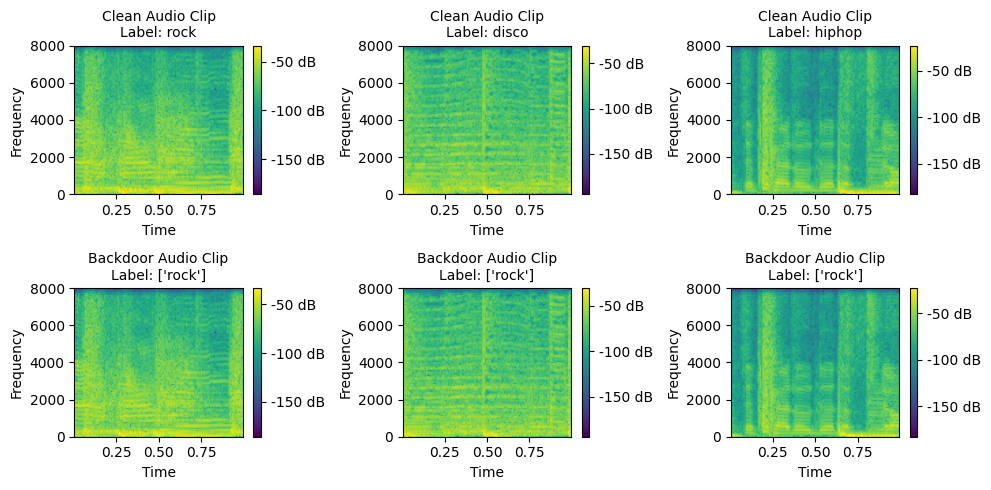

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 5))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Backdoor Audio Clip\nLabel: {}'.format(y_test_audio_bd[0]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("1_fig_plot_audio_comparison_backdoor.png", bbox_inches='tight')
plt.show()

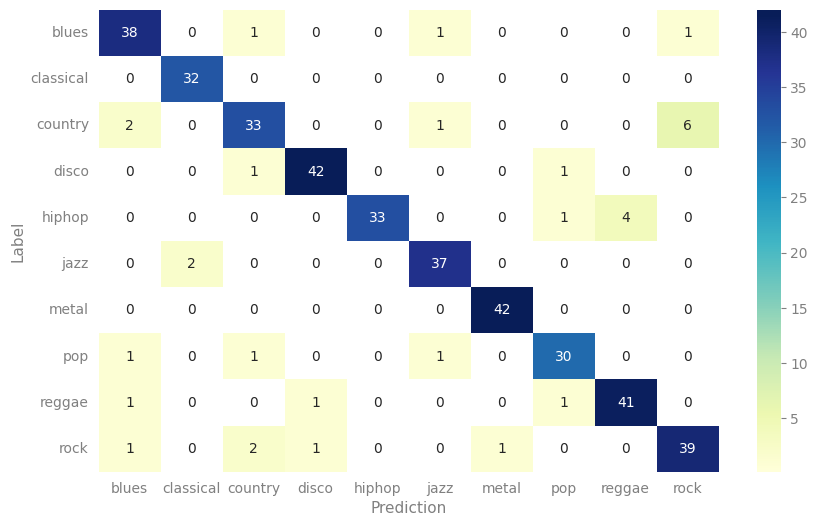

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set the color palette
cmap = ListedColormap(sns.color_palette("YlGnBu", as_cmap=True)(np.arange(259)))
cmap.set_under(color='white')

# Compute the confusion matrix and test accuracy
y_pred = np.argmax(classifier.predict(x_test), axis=1)
y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)

# Set the plot style to a white background with gridlines
sns.set_style("whitegrid", {"axes.facecolor": "white"})

# Set the font size and color of the text elements
plt.rcParams.update({
    'font.size': 10,
    'text.color': 'gray',
    'axes.labelcolor': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray',
})

# Plot the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap=cmap,
            cbar=True,
            vmin=0.15)  # set vmin to avoid white cells
plt.xlabel('Prediction', fontsize=11, color="gray")
plt.ylabel('Label', fontsize=11, color="gray")
#plt.title(f'Test set accuracy: {test_acc:.10%}', fontsize=16, color="gray")
plt.tick_params(axis='both', labelsize=10, colors="gray")
plt.savefig('fig_confusion_mtx_clean' , bbox_inches='tight')
plt.show()

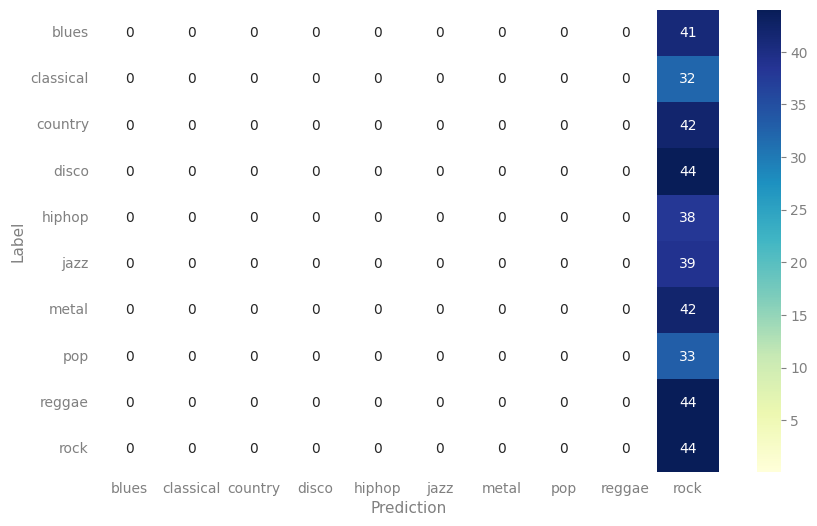

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set the color palette
cmap = ListedColormap(sns.color_palette("YlGnBu", as_cmap=True)(np.arange(256)))
cmap.set_under(color='white')

# Compute the confusion matrix and test accuracy
y_pred = np.argmax(classifier_bd.predict(x_test), axis=1)
y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)

# Set the plot style to a white background with gridlines
sns.set_style("whitegrid", {"axes.facecolor": "white"})

# Set the font size and color of the text elements
plt.rcParams.update({
    'font.size': 10,
    'text.color': 'gray',
    'axes.labelcolor': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray',
})

# Plot the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap=cmap,
            cbar=True,
            vmin=0.1)  # set vmin to avoid white cells
plt.xlabel('Prediction', fontsize=11, color="gray")
plt.ylabel('Label', fontsize=11, color="gray")
#plt.title(f'Test set accuracy: {test_acc:.10%}', fontsize=16, color="gray")
plt.tick_params(axis='both', labelsize=10, colors="gray")
plt.savefig('fig_confusion_mtx_backdoor' , bbox_inches='tight')
plt.show()